<a href="https://colab.research.google.com/github/prasvijaya/datascienceportfolio/blob/master/timeseries_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from platform import python_version
print(python_version())

3.6.9


In [2]:
from google.colab import files
uploaded = files.upload()

Saving hotel_bookings.csv to hotel_bookings.csv


In [60]:
dtypes = {
        'is_canceled':'float64',
        'lead_time':'float64',
        'stays_in_weekend_nights':'float64',
        'stays_in_week_nights':'float64',
        'adults':'float64',
        'children':'float64',
        'babies':'float64',
        'meal':'category',
        'country':'category',
        'market_segment':'category',
        'distribution_channel':'category',
        'is_repeated_guest':'float64',
        'previous_cancellations':'float64',
        'previous_bookings_not_canceled':'float64',
        'reserved_room_type':'category',
        'assigned_room_type':'category',
        'booking_changes':'float64',
        'deposit_type':'category',
        'agent':'category',
        'company':'category',
        'days_in_waiting_list':'float64',
        'customer_type':'category',
        'adr':'float64',
        'required_car_parking_spaces':'float64',
        'total_of_special_requests':'float64',
        'reservation_status':'category'
        }

In [61]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

train_df = pd.read_csv("hotel_bookings.csv", dtype=dtypes, converters={'arrival_date_week_number': '{:0>2}'.format})
train_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0.0,342.0,2015,July,27,1,0.0,0.0,2.0,0.0,0.0,BB,PRT,Direct,Direct,0.0,0.0,0.0,C,C,3.0,No Deposit,NaN,NaN,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
1,Resort Hotel,0.0,737.0,2015,July,27,1,0.0,0.0,2.0,0.0,0.0,BB,PRT,Direct,Direct,0.0,0.0,0.0,C,C,4.0,No Deposit,NaN,NaN,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
2,Resort Hotel,0.0,7.0,2015,July,27,1,0.0,1.0,1.0,0.0,0.0,BB,GBR,Direct,Direct,0.0,0.0,0.0,A,C,0.0,No Deposit,NaN,NaN,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
3,Resort Hotel,0.0,13.0,2015,July,27,1,0.0,1.0,1.0,0.0,0.0,BB,GBR,Corporate,Corporate,0.0,0.0,0.0,A,A,0.0,No Deposit,304,NaN,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
4,Resort Hotel,0.0,14.0,2015,July,27,1,0.0,2.0,2.0,0.0,0.0,BB,GBR,Online TA,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,240,NaN,0.0,Transient,98.00,0.0,1.0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0.0,23.0,2017,August,35,30,2.0,5.0,2.0,0.0,0.0,BB,BEL,Offline TA/TO,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,394,NaN,0.0,Transient,96.14,0.0,0.0,Check-Out,2017-09-06
119386,City Hotel,0.0,102.0,2017,August,35,31,2.0,5.0,3.0,0.0,0.0,BB,FRA,Online TA,TA/TO,0.0,0.0,0.0,E,E,0.0,No Deposit,9,NaN,0.0,Transient,225.43,0.0,2.0,Check-Out,2017-09-07
119387,City Hotel,0.0,34.0,2017,August,35,31,2.0,5.0,2.0,0.0,0.0,BB,DEU,Online TA,TA/TO,0.0,0.0,0.0,D,D,0.0,No Deposit,9,NaN,0.0,Transient,157.71,0.0,4.0,Check-Out,2017-09-07
119388,City Hotel,0.0,109.0,2017,August,35,31,2.0,5.0,2.0,0.0,0.0,BB,GBR,Online TA,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,89,NaN,0.0,Transient,104.40,0.0,0.0,Check-Out,2017-09-07


In [62]:
train_df.shape

(119390, 32)

In [149]:
train_df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   hotel                           119390 non-null  object  
 1   is_canceled                     119390 non-null  float64 
 2   lead_time                       119390 non-null  float64 
 3   arrival_date_year               119390 non-null  int64   
 4   arrival_date_month              119390 non-null  object  
 5   arrival_date_week_number        119390 non-null  object  
 6   arrival_date_day_of_month       119390 non-null  int64   
 7   stays_in_weekend_nights         119390 non-null  float64 
 8   stays_in_week_nights            119390 non-null  float64 
 9   adults                          119390 non-null  float64 
 10  children                        119386 non-null  float64 
 11  babies                          119390 non-null  float64 
 12  me

In [64]:
a=train_df.head()
b=train_df
b

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0.0,342.0,2015,July,27,1,0.0,0.0,2.0,0.0,0.0,BB,PRT,Direct,Direct,0.0,0.0,0.0,C,C,3.0,No Deposit,NaN,NaN,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
1,Resort Hotel,0.0,737.0,2015,July,27,1,0.0,0.0,2.0,0.0,0.0,BB,PRT,Direct,Direct,0.0,0.0,0.0,C,C,4.0,No Deposit,NaN,NaN,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
2,Resort Hotel,0.0,7.0,2015,July,27,1,0.0,1.0,1.0,0.0,0.0,BB,GBR,Direct,Direct,0.0,0.0,0.0,A,C,0.0,No Deposit,NaN,NaN,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
3,Resort Hotel,0.0,13.0,2015,July,27,1,0.0,1.0,1.0,0.0,0.0,BB,GBR,Corporate,Corporate,0.0,0.0,0.0,A,A,0.0,No Deposit,304,NaN,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
4,Resort Hotel,0.0,14.0,2015,July,27,1,0.0,2.0,2.0,0.0,0.0,BB,GBR,Online TA,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,240,NaN,0.0,Transient,98.00,0.0,1.0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0.0,23.0,2017,August,35,30,2.0,5.0,2.0,0.0,0.0,BB,BEL,Offline TA/TO,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,394,NaN,0.0,Transient,96.14,0.0,0.0,Check-Out,2017-09-06
119386,City Hotel,0.0,102.0,2017,August,35,31,2.0,5.0,3.0,0.0,0.0,BB,FRA,Online TA,TA/TO,0.0,0.0,0.0,E,E,0.0,No Deposit,9,NaN,0.0,Transient,225.43,0.0,2.0,Check-Out,2017-09-07
119387,City Hotel,0.0,34.0,2017,August,35,31,2.0,5.0,2.0,0.0,0.0,BB,DEU,Online TA,TA/TO,0.0,0.0,0.0,D,D,0.0,No Deposit,9,NaN,0.0,Transient,157.71,0.0,4.0,Check-Out,2017-09-07
119388,City Hotel,0.0,109.0,2017,August,35,31,2.0,5.0,2.0,0.0,0.0,BB,GBR,Online TA,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,89,NaN,0.0,Transient,104.40,0.0,0.0,Check-Out,2017-09-07


In [65]:
c=b.sort_values(['arrival_date_year','arrival_date_week_number'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [66]:
df = DataFrame(c, columns= ['arrival_date_year', 'arrival_date_week_number']) 
df

,arrival_date_year,arrival_date_week_number
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
119385,2017,35
119386,2017,35
119387,2017,35
119388,2017,35


In [67]:
# https://datatofish.com/concatenate-values-python/

df1 = df['arrival_date_year'].map(str) + df['arrival_date_week_number'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0         201527
1         201527
2         201527
3         201527
4         201527
           ...  
119385    201735
119386    201735
119387    201735
119388    201735
119389    201735
Length: 119390, dtype: object


In [68]:
df2= c['is_canceled']
df2

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119385    0.0
119386    0.0
119387    0.0
119388    0.0
119389    0.0
Name: is_canceled, Length: 119390, dtype: float64

In [69]:
type(df1)

pandas.core.frame.DataFrame

In [70]:
df3=pd.concat([df1, df2], axis = 1)
df3.columns = ['FullDate', 'IsCanceled']
df3

,FullDate,IsCanceled
0,201527,0.0
1,201527,0.0
2,201527,0.0
3,201527,0.0
4,201527,0.0
...,...,...
119385,201735,0.0
119386,201735,0.0
119387,201735,0.0
119388,201735,0.0


In [71]:
df3.sort_values(['FullDate','IsCanceled'], ascending=True)

,FullDate,IsCanceled
0,201527,0.0
1,201527,0.0
2,201527,0.0
3,201527,0.0
4,201527,0.0
...,...,...
73710,201735,1.0
73711,201735,1.0
73712,201735,1.0
73713,201735,1.0


In [72]:
df4 = df3.groupby('FullDate').agg(sum)
df4.sort_values(['FullDate'], ascending=True)
df4

,IsCanceled
FullDate,
201527,138.0
201528,201.0
201529,315.0
201530,395.0
201531,260.0
...,...
201731,426.0
201732,409.0
201733,523.0


In [73]:
tseries=df4['IsCanceled']
tseries

FullDate
201527    138.0
201528    201.0
201529    315.0
201530    395.0
201531    260.0
          ...  
201731    426.0
201732    409.0
201733    523.0
201734    344.0
201735    229.0
Name: IsCanceled, Length: 115, dtype: float64

Visualize the Timeseries and understand TimeSeries Pattern

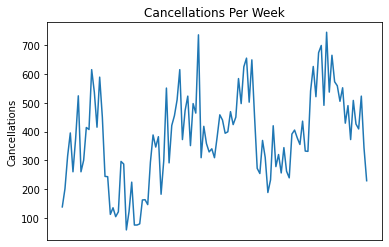

In [74]:
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Cancellations')
plt.title("Cancellations Per Week")
plt.show()

**There is a seasonality present in Cancellations**

##### Run Augmented Dickey Fuller Test to confirm if the timeseries are Stationary or not

In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [76]:
# Run the ADF test on the series and print out the results
results = adfuller(tseries)
print(results)

(-2.957580251555882, 0.03905028280956615, 10, 104, {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}, 1239.419112291575)


In [77]:
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.957580
p-value: 0.039050
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


p-value < 0.05, so we can accept the Null Hypothesis that the timeseries is Stationary. Hence, the Dicky Fuller test says Time series is stationary

In [78]:
df=pd.DataFrame(tseries)
df

,IsCanceled
FullDate,
201527,138.0
201528,201.0
201529,315.0
201530,395.0
201531,260.0
...,...
201731,426.0
201732,409.0
201733,523.0


In [79]:
df=np.array(df)

**Training and Validation data partition**

In [80]:
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

**Form dataset matrix**

In [81]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [82]:
df

array([[138.],
       [201.],
       [315.],
       [395.],
       [260.],
       [376.],
       [524.],
       [260.],
       [300.],
       [414.],
       [407.],
       [615.],
       [537.],
       [415.],
       [589.],
       [450.],
       [244.],
       [243.],
       [112.],
       [135.],
       [104.],
       [121.],
       [296.],
       [287.],
       [ 58.],
       [122.],
       [224.],
       [ 75.],
       [ 75.],
       [ 79.],
       [162.],
       [163.],
       [146.],
       [293.],
       [388.],
       [346.],
       [382.],
       [182.],
       [298.],
       [551.],
       [291.],
       [421.],
       [455.],
       [510.],
       [615.],
       [372.],
       [473.],
       [523.],
       [351.],
       [497.],
       [464.],
       [736.],
       [309.],
       [418.],
       [358.],
       [329.],
       [340.],
       [309.],
       [381.],
       [458.],
       [440.],
       [394.],
       [399.],
       [469.],
       [424.],
       [450.],
       [58

**Normalize dataset with MinMaxScaler**

In [83]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
train

array([[0.1179941 ],
       [0.21091445],
       [0.37905605],
       [0.49705015],
       [0.2979351 ],
       [0.46902655],
       [0.68731563],
       [0.2979351 ],
       [0.35693215],
       [0.52507375],
       [0.51474926],
       [0.82153392],
       [0.70648968],
       [0.52654867],
       [0.78318584],
       [0.57817109],
       [0.27433628],
       [0.27286136],
       [0.07964602],
       [0.11356932],
       [0.06784661],
       [0.09292035],
       [0.35103245],
       [0.33775811],
       [0.        ],
       [0.09439528],
       [0.24483776],
       [0.02507375],
       [0.02507375],
       [0.03097345],
       [0.15339233],
       [0.15486726],
       [0.12979351],
       [0.34660767],
       [0.48672566],
       [0.42477876],
       [0.47787611],
       [0.18289086],
       [0.3539823 ],
       [0.72713864],
       [0.34365782],
       [0.53539823],
       [0.58554572],
       [0.66666667],
       [0.82153392],
       [0.46312684],
       [0.6120944 ],
       [0.685

In [84]:
val = scaler.fit_transform(val)
val

array([[0.19767442],
       [0.60465116],
       [0.76937984],
       [0.56589147],
       [0.8624031 ],
       [0.91085271],
       [0.50775194],
       [1.        ],
       [0.59689922],
       [0.84496124],
       [0.66666667],
       [0.63953488],
       [0.53488372],
       [0.62596899],
       [0.3875969 ],
       [0.50581395],
       [0.27713178],
       [0.54069767],
       [0.38178295],
       [0.34883721],
       [0.56976744],
       [0.22286822],
       [0.        ]])

In [85]:
# Lookback period
lookback = 5
X_train, y_train = create_dataset(train, lookback)
X_val, y_val = create_dataset(val, lookback)

In [86]:
X_train

array([[0.1179941 , 0.21091445, 0.37905605, 0.49705015, 0.2979351 ],
       [0.21091445, 0.37905605, 0.49705015, 0.2979351 , 0.46902655],
       [0.37905605, 0.49705015, 0.2979351 , 0.46902655, 0.68731563],
       [0.49705015, 0.2979351 , 0.46902655, 0.68731563, 0.2979351 ],
       [0.2979351 , 0.46902655, 0.68731563, 0.2979351 , 0.35693215],
       [0.46902655, 0.68731563, 0.2979351 , 0.35693215, 0.52507375],
       [0.68731563, 0.2979351 , 0.35693215, 0.52507375, 0.51474926],
       [0.2979351 , 0.35693215, 0.52507375, 0.51474926, 0.82153392],
       [0.35693215, 0.52507375, 0.51474926, 0.82153392, 0.70648968],
       [0.52507375, 0.51474926, 0.82153392, 0.70648968, 0.52654867],
       [0.51474926, 0.82153392, 0.70648968, 0.52654867, 0.78318584],
       [0.82153392, 0.70648968, 0.52654867, 0.78318584, 0.57817109],
       [0.70648968, 0.52654867, 0.78318584, 0.57817109, 0.27433628],
       [0.52654867, 0.78318584, 0.57817109, 0.27433628, 0.27286136],
       [0.78318584, 0.57817109, 0.

In [87]:
y_train

array([0.46902655, 0.68731563, 0.2979351 , 0.35693215, 0.52507375,
       0.51474926, 0.82153392, 0.70648968, 0.52654867, 0.78318584,
       0.57817109, 0.27433628, 0.27286136, 0.07964602, 0.11356932,
       0.06784661, 0.09292035, 0.35103245, 0.33775811, 0.        ,
       0.09439528, 0.24483776, 0.02507375, 0.02507375, 0.03097345,
       0.15339233, 0.15486726, 0.12979351, 0.34660767, 0.48672566,
       0.42477876, 0.47787611, 0.18289086, 0.3539823 , 0.72713864,
       0.34365782, 0.53539823, 0.58554572, 0.66666667, 0.82153392,
       0.46312684, 0.6120944 , 0.68584071, 0.43215339, 0.64749263,
       0.59882006, 1.        , 0.37020649, 0.53097345, 0.44247788,
       0.39970501, 0.4159292 , 0.37020649, 0.47640118, 0.5899705 ,
       0.56342183, 0.49557522, 0.50294985, 0.60619469, 0.53982301,
       0.57817109, 0.77581121, 0.64749263, 0.83628319, 0.88053097,
       0.65486726, 0.87168142, 0.5840708 , 0.31563422, 0.28908555,
       0.45870206, 0.37168142, 0.19174041, 0.25663717, 0.53392

**Configure LSTM model**

In [88]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

X_train

array([[[0.1179941 , 0.21091445, 0.37905605, 0.49705015, 0.2979351 ]],

       [[0.21091445, 0.37905605, 0.49705015, 0.2979351 , 0.46902655]],

       [[0.37905605, 0.49705015, 0.2979351 , 0.46902655, 0.68731563]],

       [[0.49705015, 0.2979351 , 0.46902655, 0.68731563, 0.2979351 ]],

       [[0.2979351 , 0.46902655, 0.68731563, 0.2979351 , 0.35693215]],

       [[0.46902655, 0.68731563, 0.2979351 , 0.35693215, 0.52507375]],

       [[0.68731563, 0.2979351 , 0.35693215, 0.52507375, 0.51474926]],

       [[0.2979351 , 0.35693215, 0.52507375, 0.51474926, 0.82153392]],

       [[0.35693215, 0.52507375, 0.51474926, 0.82153392, 0.70648968]],

       [[0.52507375, 0.51474926, 0.82153392, 0.70648968, 0.52654867]],

       [[0.51474926, 0.82153392, 0.70648968, 0.52654867, 0.78318584]],

       [[0.82153392, 0.70648968, 0.52654867, 0.78318584, 0.57817109]],

       [[0.70648968, 0.52654867, 0.78318584, 0.57817109, 0.27433628]],

       [[0.52654867, 0.78318584, 0.57817109, 0.27433628, 0.27286

In [89]:
X_val

array([[[0.19767442, 0.60465116, 0.76937984, 0.56589147, 0.8624031 ]],

       [[0.60465116, 0.76937984, 0.56589147, 0.8624031 , 0.91085271]],

       [[0.76937984, 0.56589147, 0.8624031 , 0.91085271, 0.50775194]],

       [[0.56589147, 0.8624031 , 0.91085271, 0.50775194, 1.        ]],

       [[0.8624031 , 0.91085271, 0.50775194, 1.        , 0.59689922]],

       [[0.91085271, 0.50775194, 1.        , 0.59689922, 0.84496124]],

       [[0.50775194, 1.        , 0.59689922, 0.84496124, 0.66666667]],

       [[1.        , 0.59689922, 0.84496124, 0.66666667, 0.63953488]],

       [[0.59689922, 0.84496124, 0.66666667, 0.63953488, 0.53488372]],

       [[0.84496124, 0.66666667, 0.63953488, 0.53488372, 0.62596899]],

       [[0.66666667, 0.63953488, 0.53488372, 0.62596899, 0.3875969 ]],

       [[0.63953488, 0.53488372, 0.62596899, 0.3875969 , 0.50581395]],

       [[0.53488372, 0.62596899, 0.3875969 , 0.50581395, 0.27713178]],

       [[0.62596899, 0.3875969 , 0.50581395, 0.27713178, 0.54069

In [90]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, mean_squared_error

In [91]:
# Generate LSTM network
model= Sequential([
    LSTM(4, input_shape=(1, lookback)),
    Dense(1),
])

In [92]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 160       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [94]:
history=model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
68/68 - 1s - loss: 0.3303 - val_loss: 0.1399
Epoch 2/20
68/68 - 0s - loss: 0.2103 - val_loss: 0.0696
Epoch 3/20
68/68 - 0s - loss: 0.1246 - val_loss: 0.0239
Epoch 4/20
68/68 - 0s - loss: 0.0688 - val_loss: 0.0125
Epoch 5/20
68/68 - 0s - loss: 0.0466 - val_loss: 0.0160
Epoch 6/20
68/68 - 0s - loss: 0.0412 - val_loss: 0.0210
Epoch 7/20
68/68 - 0s - loss: 0.0404 - val_loss: 0.0231
Epoch 8/20
68/68 - 0s - loss: 0.0397 - val_loss: 0.0210
Epoch 9/20
68/68 - 0s - loss: 0.0392 - val_loss: 0.0211
Epoch 10/20
68/68 - 0s - loss: 0.0386 - val_loss: 0.0224
Epoch 11/20
68/68 - 0s - loss: 0.0377 - val_loss: 0.0216
Epoch 12/20
68/68 - 0s - loss: 0.0373 - val_loss: 0.0222
Epoch 13/20
68/68 - 0s - loss: 0.0370 - val_loss: 0.0233
Epoch 14/20
68/68 - 0s - loss: 0.0372 - val_loss: 0.0235
Epoch 15/20
68/68 - 0s - loss: 0.0361 - val_loss: 0.0231
Epoch 16/20
68/68 - 0s - loss: 0.0355 - val_loss: 0.0216
Epoch 17/20
68/68 - 0s - loss: 0.0355 - val_loss: 0.0219
Epoch 18/20
68/68 - 0s - loss: 0.0348 - 

Loss History Graph

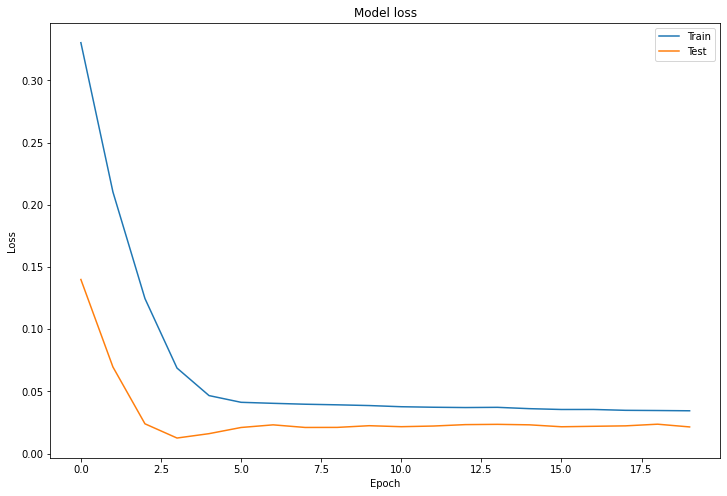

In [95]:
def plot_loss(loss, val_loss):
  plt.figure(figsize=(12,8))
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()


# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

In [96]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [97]:
trainpred

array([[0.34049192],
       [0.4444182 ],
       [0.5204859 ],
       [0.40915358],
       [0.46104455],
       [0.5222825 ],
       [0.47998342],
       [0.5395541 ],
       [0.555447  ],
       [0.5483272 ],
       [0.6382109 ],
       [0.60054696],
       [0.50101906],
       [0.51226497],
       [0.42720288],
       [0.35206902],
       [0.28977242],
       [0.25785667],
       [0.30377096],
       [0.29450694],
       [0.22689593],
       [0.31680736],
       [0.3481698 ],
       [0.2234292 ],
       [0.22778037],
       [0.25326937],
       [0.25167194],
       [0.22743386],
       [0.23185739],
       [0.3133862 ],
       [0.3609115 ],
       [0.3586809 ],
       [0.4309176 ],
       [0.40092182],
       [0.45221034],
       [0.51525575],
       [0.38295954],
       [0.47384107],
       [0.54037243],
       [0.54624784],
       [0.584244  ],
       [0.53603077],
       [0.5965158 ],
       [0.61582553],
       [0.5275395 ],
       [0.57266134],
       [0.572165  ],
       [0.637

In [98]:
valpred

array([[0.6019783 ],
       [0.6643417 ],
       [0.5795676 ],
       [0.6971958 ],
       [0.6427329 ],
       [0.6614267 ],
       [0.64223295],
       [0.6316823 ],
       [0.6007161 ],
       [0.6088482 ],
       [0.5287053 ],
       [0.53938377],
       [0.4717536 ],
       [0.5071765 ],
       [0.44939142],
       [0.42872325],
       [0.49600083]], dtype=float32)

In [99]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
y_train = scaler.inverse_transform([y_train])
valpred = scaler.inverse_transform(valpred)
y_val = scaler.inverse_transform([y_val])
predictions = valpred

In [100]:
type(predictions)

numpy.ndarray

In [101]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((86, 1, 5), (17, 1, 5), (1, 86), (1, 17))

In [102]:
np.mean(y_val)

519.2352941176471

In [103]:
X_train[:10]

array([[[0.1179941 , 0.21091445, 0.37905605, 0.49705015, 0.2979351 ]],

       [[0.21091445, 0.37905605, 0.49705015, 0.2979351 , 0.46902655]],

       [[0.37905605, 0.49705015, 0.2979351 , 0.46902655, 0.68731563]],

       [[0.49705015, 0.2979351 , 0.46902655, 0.68731563, 0.2979351 ]],

       [[0.2979351 , 0.46902655, 0.68731563, 0.2979351 , 0.35693215]],

       [[0.46902655, 0.68731563, 0.2979351 , 0.35693215, 0.52507375]],

       [[0.68731563, 0.2979351 , 0.35693215, 0.52507375, 0.51474926]],

       [[0.2979351 , 0.35693215, 0.52507375, 0.51474926, 0.82153392]],

       [[0.35693215, 0.52507375, 0.51474926, 0.82153392, 0.70648968]],

       [[0.52507375, 0.51474926, 0.82153392, 0.70648968, 0.52654867]]])

In [104]:
X_val[:10]

array([[[0.19767442, 0.60465116, 0.76937984, 0.56589147, 0.8624031 ]],

       [[0.60465116, 0.76937984, 0.56589147, 0.8624031 , 0.91085271]],

       [[0.76937984, 0.56589147, 0.8624031 , 0.91085271, 0.50775194]],

       [[0.56589147, 0.8624031 , 0.91085271, 0.50775194, 1.        ]],

       [[0.8624031 , 0.91085271, 0.50775194, 1.        , 0.59689922]],

       [[0.91085271, 0.50775194, 1.        , 0.59689922, 0.84496124]],

       [[0.50775194, 1.        , 0.59689922, 0.84496124, 0.66666667]],

       [[1.        , 0.59689922, 0.84496124, 0.66666667, 0.63953488]],

       [[0.59689922, 0.84496124, 0.66666667, 0.63953488, 0.53488372]],

       [[0.84496124, 0.66666667, 0.63953488, 0.53488372, 0.62596899]]])

In [105]:
import math
from math import sqrt

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 90.91 RMSE
Validation Score: 97.02 RMSE


In [106]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [107]:
# Validation predictions
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = valpred

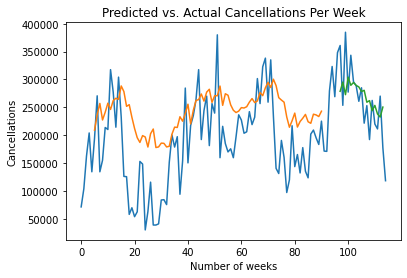

In [108]:
# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(scaler.inverse_transform(trainpredPlot))
valpred, =plt.plot(scaler.inverse_transform(valpredPlot))
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Cancellations Per Week")
plt.show()

In [109]:
y_val=y_val.reshape(-1)
y_val.shape
y_val=pd.Series(y_val)
y_val[:10]

0    699.0
1    491.0
2    745.0
3    537.0
4    665.0
5    573.0
6    559.0
7    505.0
8    552.0
9    429.0
dtype: float64

In [110]:
np.mean(y_val)

519.2352941176471

In [111]:
predictions=predictions.reshape(-1)

In [112]:
predictions.shape

(17,)

In [113]:
predictions=pd.Series(predictions)
predictions

0     539.620789
1     571.800293
2     528.056885
3     588.753052
4     560.650208
5     570.296204
6     560.392212
7     554.948059
8     538.969482
9     543.165649
10    501.811920
11    507.322021
12    472.424835
13    490.703064
14    460.885956
15    450.221191
16    484.936401
dtype: float32

In [115]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [116]:
mda(y_val, predictions)

0.8823529411764706

In [117]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

mse = mean_squared_error(y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 97.021905


In [118]:
forecast_error = (predictions-y_val)
forecast_error

0    -159.379211
1      80.800293
2    -216.943115
3      51.753052
4    -104.349792
5      -2.703796
6       1.392212
7      49.948059
8     -13.030518
9     114.165649
10     11.811920
11    135.322021
12    -35.575165
13     64.703064
14     51.885956
15    -72.778809
16    140.936401
dtype: float64

In [119]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

5.762248319738052

In [121]:
X_train[:10]

array([[[0.1179941 , 0.21091445, 0.37905605, 0.49705015, 0.2979351 ]],

       [[0.21091445, 0.37905605, 0.49705015, 0.2979351 , 0.46902655]],

       [[0.37905605, 0.49705015, 0.2979351 , 0.46902655, 0.68731563]],

       [[0.49705015, 0.2979351 , 0.46902655, 0.68731563, 0.2979351 ]],

       [[0.2979351 , 0.46902655, 0.68731563, 0.2979351 , 0.35693215]],

       [[0.46902655, 0.68731563, 0.2979351 , 0.35693215, 0.52507375]],

       [[0.68731563, 0.2979351 , 0.35693215, 0.52507375, 0.51474926]],

       [[0.2979351 , 0.35693215, 0.52507375, 0.51474926, 0.82153392]],

       [[0.35693215, 0.52507375, 0.51474926, 0.82153392, 0.70648968]],

       [[0.52507375, 0.51474926, 0.82153392, 0.70648968, 0.52654867]]])

In [122]:
X_train.shape

(86, 1, 5)

**Validate Predictions on Test Data**

In [123]:
# Test (unseen) predictions
# (t) and (t-5)
Xnew = np.array([tseries.iloc[95:100],tseries.iloc[96:101],tseries.iloc[97:102],tseries.iloc[98:103],tseries.iloc[99:104],tseries.iloc[100:105],tseries.iloc[101:106],tseries.iloc[102:107],tseries.iloc[103:108],tseries.iloc[104:109],tseries.iloc[105:110],tseries.iloc[106:111],tseries.iloc[107:112],tseries.iloc[108:113],tseries.iloc[109:114]])

In [124]:
Xnew[:10]

array([[521., 674., 699., 491., 745.],
       [674., 699., 491., 745., 537.],
       [699., 491., 745., 537., 665.],
       [491., 745., 537., 665., 573.],
       [745., 537., 665., 573., 559.],
       [537., 665., 573., 559., 505.],
       [665., 573., 559., 505., 552.],
       [573., 559., 505., 552., 429.],
       [559., 505., 552., 429., 490.],
       [505., 552., 429., 490., 372.]])

In [125]:
Xnew = scaler.fit_transform(Xnew)
Xnew
Xnewformat = np.reshape(Xnew, (Xnew.shape[0], 1, Xnew.shape[1]))
ynew=model.predict(Xnewformat)

In [126]:
Xnew.shape

(15, 5)

In [127]:
ynew

array([[0.6681395 ],
       [0.59384775],
       [0.61742085],
       [0.59222245],
       [0.5772679 ],
       [0.5342542 ],
       [0.54507774],
       [0.42718765],
       [0.4430006 ],
       [0.34797847],
       [0.39350033],
       [0.31088328],
       [0.28188685],
       [0.3760996 ],
       [0.24783318]], dtype=float32)

In [129]:
type(ynew)

numpy.ndarray

In [130]:
print(ynew.shape)

(15, 1)


In [131]:
actual = tseries.iloc[100:115]
actual

FullDate
201721    537.0
201722    665.0
201723    573.0
201724    559.0
201725    505.0
201726    552.0
201727    429.0
201728    490.0
201729    372.0
201730    508.0
201731    426.0
201732    409.0
201733    523.0
201734    344.0
201735    229.0
Name: IsCanceled, dtype: float64

In [132]:
actual = np.array(actual)
actual

array([537., 665., 573., 559., 505., 552., 429., 490., 372., 508., 426.,
       409., 523., 344., 229.])

In [133]:
actual=actual.reshape(15,-1)
actual.shape

(15, 1)

In [134]:
actual

array([[537.],
       [665.],
       [573.],
       [559.],
       [505.],
       [552.],
       [429.],
       [490.],
       [372.],
       [508.],
       [426.],
       [409.],
       [523.],
       [344.],
       [229.]])

In [135]:
ynew=ynew.reshape(-1)
actual=actual.reshape(-1)
actualpd=pd.Series(actual)

In [136]:
np.min(df)

58.0

In [137]:
ynew

array([0.6681395 , 0.59384775, 0.61742085, 0.59222245, 0.5772679 ,
       0.5342542 , 0.54507774, 0.42718765, 0.4430006 , 0.34797847,
       0.39350033, 0.31088328, 0.28188685, 0.3760996 , 0.24783318],
      dtype=float32)

In [138]:
maxcancel=np.max(tseries)

In [139]:
mincancel=np.min(tseries)

In [140]:
ynew = ynew * np.abs(maxcancel-mincancel) + np.min(tseries)
ynewpd=pd.Series(ynew)

In [141]:
actualpd

0     537.0
1     665.0
2     573.0
3     559.0
4     505.0
5     552.0
6     429.0
7     490.0
8     372.0
9     508.0
10    426.0
11    409.0
12    523.0
13    344.0
14    229.0
dtype: float64

In [142]:
ynewpd

0     517.011841
1     465.973419
2     482.168121
3     464.856812
4     454.583038
5     425.032623
6     432.468414
7     351.477905
8     362.341431
9     297.061218
10    328.334717
11    271.576813
12    251.656265
13    316.380402
14    228.261398
dtype: float32

In [143]:
mda(actualpd, ynewpd)

0.8666666666666667

In [144]:
mse = mean_squared_error(actualpd, ynewpd)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 127.119465


In [145]:
forecast_error = (ynewpd-actualpd)
forecast_error

0     -19.988159
1    -199.026581
2     -90.831879
3     -94.143188
4     -50.416962
5    -126.967377
6       3.468414
7    -138.522095
8      -9.658569
9    -210.938782
10    -97.665283
11   -137.423187
12   -271.343735
13    -27.619598
14     -0.738602
dtype: float64

In [146]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-98.12103881835938

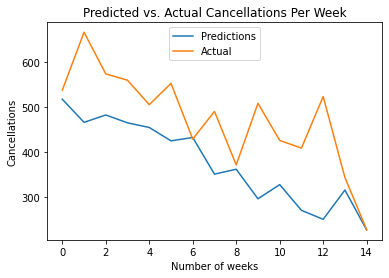

In [147]:
predictons, =plt.plot(ynewpd, label='Predictions')
actual, =plt.plot(actualpd, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Cancellations Per Week")
plt.legend(loc = 'upper center')
plt.show()

In [148]:
np.mean(ynewpd)

376.6122741699219